<a href="https://colab.research.google.com/github/nicolassalomon96/aprendizaje_maquina_UNS/blob/master/TP2/Ejercicio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 - Ejercicio 2

Presentado: Nicolás Salomón - email: nicolassalomon96@gmail.com

Generar un dataset similar al de la pág. 12 de este apunte (dos conjuntos Gaussianos con diferente media y DS, N=50 c/u, uno con etiqueta A y otro con etiqueta B).
Utilizar la curva ROC para proponer un umbral para un clasificador por mínimo error. Evaluar algunos de los parámetros de calidad (exactitud, precisión, f-measure).
Recalcular para algunas variantes (por ejemplo, acercando las medias de los grupos A y B, cambiando el valor umbral, etc.).
Cómo podrían hacer no supervisado este proceso?

# 1. Se importan librerias necesarias y se clonan los datasets del repositorio

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# 2. Generación de los datasets

In [63]:
# Semilla aletoria
np.random.seed(2)

features_number = 1
n = 50

media_a = 3 #Media del dataset A
ds_a = 1  #Desviación estandar del dataset A

media_b = 7 #Media del dataset B
ds_b = 2  #Desviación estandar del dataset B

a_df = pd.DataFrame(np.random.normal(loc = media_a, scale = ds_a, size=(n, features_number)),
                        columns=['Valor'])
a_df['Etiqueta'] = 'A'

b_df = pd.DataFrame(np.random.normal(loc = media_b, scale = ds_b, size=(n, features_number)),
                        columns=['Valor'])
b_df['Etiqueta'] = 'B'

## 2.1. Gráfica de cada dataset

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


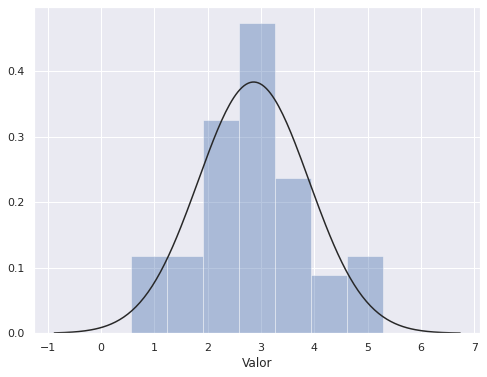

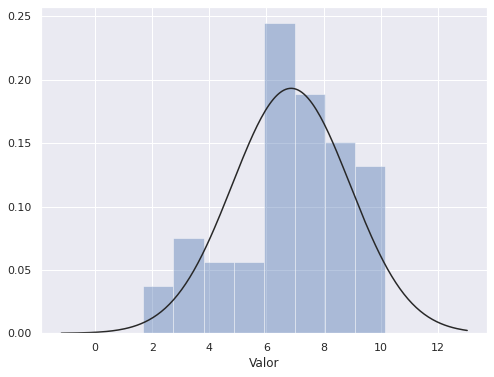

In [64]:
plt.figure(figsize=(8,6))
sns.distplot(a_df['Valor'], fit=norm ,kde=False)

plt.figure(figsize=(8,6))
sns.distplot(b_df['Valor'], fit=norm ,kde=False)

plt.show()

## 2.2. Gráfica de ambos datasets juntos

In [69]:
a_b_df = pd.DataFrame(np.concatenate([a_df['Valor'],b_df['Valor']]), columns=['Valor'])
a_b_df['Etiqueta'] = np.concatenate([a_df['Etiqueta'],b_df['Etiqueta']])

a_b_df

,Valor,Etiqueta
0,2.583242,A
1,2.943733,A
2,0.863804,A
3,4.640271,A
4,1.206564,A
...,...,...
95,9.081648,B
96,7.760944,B
97,6.565729,B
98,9.347063,B


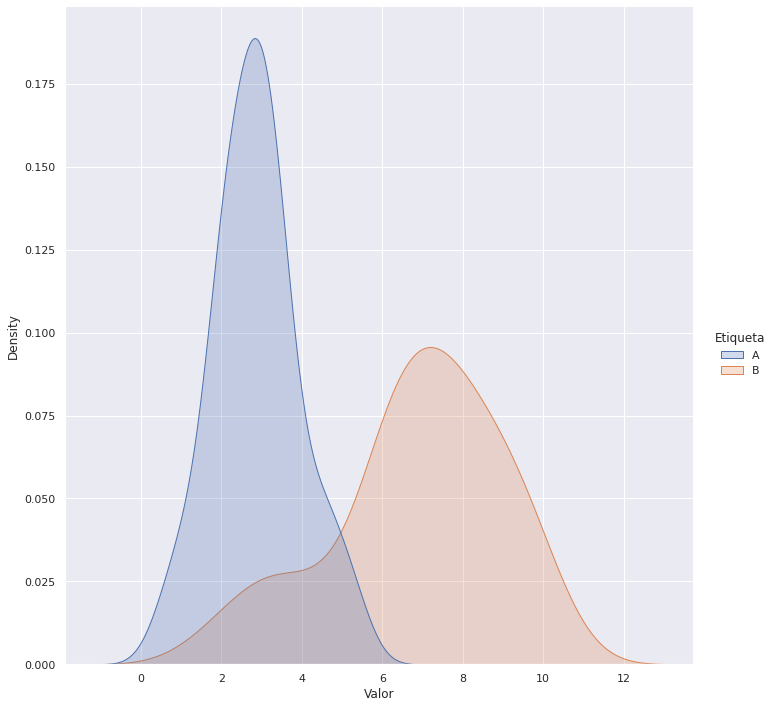

In [84]:
sns.displot(a_b_df, x='Valor', hue = 'Etiqueta', kind = 'kde', fill = True, legend=True, height=10)
plt.show()

# 3. Curva ROC

Para graficar la curva ROC vamos a suponer que los valores correctos son los valores del dataset A, mientras que los valores